# **Project Title: Predicting Start-Up Profit Using Multi-Linear Regression Analysis**

### Project Overview

This project aims to analyze a dataset containing details of start-up companies, specifically focusing on their spending in R&D, administration, and marketing, along with their location (state) and recorded profit. The goal is to build a multi-linear regression model to predict the profit of a start-up based on these features.

### Initial Steps

1. **Exploratory Data Analysis (EDA)**: We will start by understanding the structure of the dataset, checking for missing values, and identifying the data types of each column. This preliminary analysis will help us identify potential preprocessing steps, such as handling categorical data.
  
2. **Suitability of Linear Regression**: Before diving into the model, we need to assess whether linear regression is appropriate for this dataset. This involves evaluating the relationships between features and the target variable (profit) and checking for multicollinearity.

3. **Data Preparation**: Since linear regression models require numerical data, any categorical features (like 'State') will need to be converted to numerical format, typically using one-hot encoding.

4. **Model Training and Testing**: We will split the dataset into training and testing sets, with 80% of the data used for training and 20% for testing. The linear regression model will be trained on the training set and evaluated on the test set.

5. **Model Evaluation**: Finally, we will assess the model’s performance by visualizing predictions and calculating the R²-score on the test data to understand how well our model generalizes.

Now, let's start by loading and inspecting the data.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Load the dataset
data = pd.read_csv("data/StartUpProfits.csv")

# Display the first few rows to understand the data structure
print(data.head())

# Check the number of samples (rows) and features (columns)
num_samples, num_features = data.shape
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")

# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:")
print(missing_values)


   R&D Spend  Administration  Marketing Spend       State     Profit
0  165349.20       136897.80        471784.10    New York  192261.83
1  162597.70       151377.59        443898.53  California  191792.06
2  153441.51       101145.55        407934.54     Florida  191050.39
3  144372.41       118671.85        383199.62    New York  182901.99
4  142107.34        91391.77        366168.42     Florida  166187.94
Number of samples: 50
Number of features: 5
Missing values in each column:
R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64


### Initial Data Inspection Notes

- **Dataset Structure**: The dataset contains 50 samples (rows) and 5 features (columns), which include:
  - `R&D Spend`: The amount spent on research and development.
  - `Administration`: The amount spent on administrative costs.
  - `Marketing Spend`: The amount spent on marketing.
  - `State`: The location of the start-up, which is a categorical feature.
  - `Profit`: The profit generated by the start-up, which is our target variable for prediction.

- **Missing Values**: No missing values were detected in any of the columns, which means we can proceed without any data imputation steps.

- **Categorical Feature**: The `State` column is categorical and will need to be converted into numerical format (e.g., using one-hot encoding) before using it in a linear regression model.

At this point, we are ready to proceed with further exploration and preparation of the data, including transforming the categorical feature and assessing the suitability of linear regression.

The next step involves transforming the categorical variable `State` into a numerical format, as linear regression requires all features to be numeric. We'll use one-hot encoding for this transformation, which will create new columns for each unique state value, assigning binary values (0 or 1) to indicate the presence of each state.


In [2]:
# Perform one-hot encoding for the 'State' column
data = pd.get_dummies(data, columns=['State'], drop_first=True)

# Display the first few rows to confirm the transformation
print(data.head())

# Check the new shape of the data after encoding
num_samples, num_features = data.shape
print(f"Updated number of samples: {num_samples}")
print(f"Updated number of features after encoding: {num_features}")

   R&D Spend  Administration  Marketing Spend     Profit  State_Florida  \
0  165349.20       136897.80        471784.10  192261.83          False   
1  162597.70       151377.59        443898.53  191792.06          False   
2  153441.51       101145.55        407934.54  191050.39           True   
3  144372.41       118671.85        383199.62  182901.99          False   
4  142107.34        91391.77        366168.42  166187.94           True   

   State_New York  
0            True  
1           False  
2           False  
3            True  
4           False  
Updated number of samples: 50
Updated number of features after encoding: 6


### Data Transformation Notes

- **One-Hot Encoding**: The categorical `State` column has been successfully transformed into two binary columns:
  - `State_Florida`: Indicates whether the start-up is located in Florida.
  - `State_New York`: Indicates whether the start-up is located in New York.
  - The absence of both (i.e., both columns being `False`) implies that the start-up is in California, which was dropped to avoid multicollinearity.
  
- **Updated Dataset Structure**: The dataset now has 50 samples and 6 features. This includes the three original numeric features (`R&D Spend`, `Administration`, `Marketing Spend`), the target variable (`Profit`), and the two newly created binary columns representing the state.

With the dataset prepared, we can now proceed to explore the relationships between features and the target variable to assess the suitability of linear regression. This includes examining correlations and visualizing feature relationships with `Profit`.

For our exploratory analysis, we’ll start by checking the correlation between features and the target variable (`Profit`). This will help us understand the strength of the linear relationships in the data, which is crucial to determine if linear regression is appropriate.

We'll also create scatter plots to visually inspect the relationships between each feature and `Profit`.

Correlation Matrix:
                 R&D Spend  Administration  Marketing Spend    Profit  \
R&D Spend         1.000000        0.241955         0.724248  0.972900   
Administration    0.241955        1.000000        -0.032154  0.200717   
Marketing Spend   0.724248       -0.032154         1.000000  0.747766   
Profit            0.972900        0.200717         0.747766  1.000000   
State_Florida     0.105711        0.010493         0.205685  0.116244   
State_New York    0.039068        0.005145        -0.033670  0.031368   

                 State_Florida  State_New York  
R&D Spend             0.105711        0.039068  
Administration        0.010493        0.005145  
Marketing Spend       0.205685       -0.033670  
Profit                0.116244        0.031368  
State_Florida         1.000000       -0.492366  
State_New York       -0.492366        1.000000  


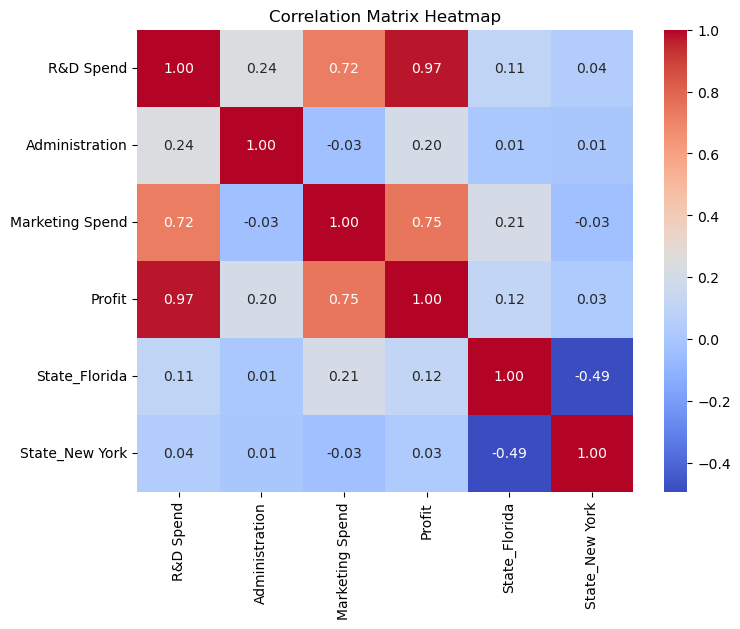

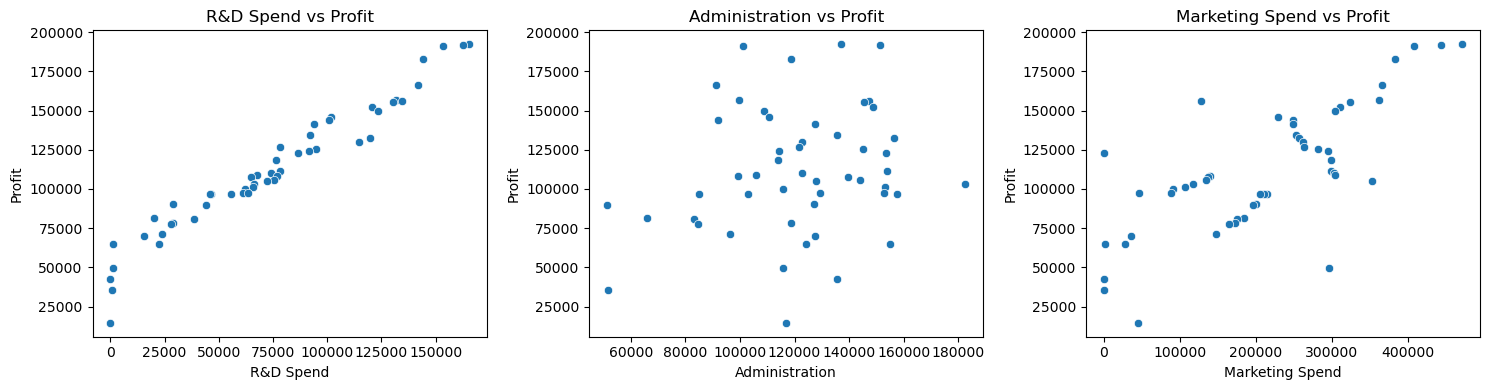

In [3]:
# Create a folder to save plots if it doesn't exist
output_folder = "plots"
os.makedirs(output_folder, exist_ok=True)

# Calculate the correlation matrix
correlation_matrix = data.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix with a heatmap and save it
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
heatmap_path = os.path.join(output_folder, "correlation_matrix_heatmap.png")
plt.savefig(heatmap_path)
plt.show()

# Plot scatter plots to visualize relationships with Profit and save them
features = ['R&D Spend', 'Administration', 'Marketing Spend']
plt.figure(figsize=(15, 4))

for i, feature in enumerate(features, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(data=data, x=feature, y='Profit')
    plt.title(f'{feature} vs Profit')

# Save the scatter plots as a single figure
scatter_plots_path = os.path.join(output_folder, "scatter_plots.png")
plt.tight_layout()
plt.savefig(scatter_plots_path)
plt.show()


### Exploratory Analysis Results

1. **Correlation Matrix Insights**:
   - **R&D Spend**: This feature has the highest correlation with `Profit` (0.97), indicating a strong positive linear relationship. This suggests that increased spending on R&D is associated with higher profits, which is a promising indicator for the suitability of linear regression.
   - **Marketing Spend**: This feature also has a significant positive correlation with `Profit` (0.75), though not as strong as R&D Spend. This suggests that marketing spend is also positively associated with profit but with more variability.
   - **Administration**: This feature has a very low correlation with `Profit` (0.20), indicating that administrative expenses may not be strongly related to profit. This could suggest that `Administration` may not be as useful in a linear regression model for predicting profit.
   - **State Variables (Florida and New York)**: The binary `State_Florida` and `State_New York` features show very low correlations with `Profit` (0.12 and 0.03, respectively), suggesting that the state where a start-up is located has little to no impact on its profit in this dataset.

2. **Scatter Plots Observations**:
   - **R&D Spend vs Profit**: There is a clear linear relationship between `R&D Spend` and `Profit`, with profits increasing as R&D spend increases. This confirms the strong positive correlation seen in the correlation matrix.
   - **Administration vs Profit**: The scatter plot for `Administration` and `Profit` shows a dispersed pattern with no clear linear trend, supporting the low correlation observed. This suggests that `Administration` may not be a significant predictor in our linear regression model.
   - **Marketing Spend vs Profit**: There is a somewhat positive trend between `Marketing Spend` and `Profit`, but the relationship is less consistent than that of `R&D Spend`. This suggests that while `Marketing Spend` may contribute to predicting `Profit`, it may have a weaker effect than `R&D Spend`.

3. **Suitability of Linear Regression**:
   - Based on the correlations and scatter plots, **linear regression appears suitable** for this dataset, particularly given the strong linear relationship between `Profit` and `R&D Spend`, as well as a moderately positive relationship with `Marketing Spend`.
   - `Administration` and `State` may not be as useful for prediction, but they can still be included in the model to assess their overall impact.

With these insights, we are ready to proceed with building and evaluating the multi-linear regression model. Let me know when you’re ready for the next steps!

R² Score: 0.8987
Mean Squared Error (MSE): 82010363.04
Root Mean Squared Error (RMSE): 9055.96


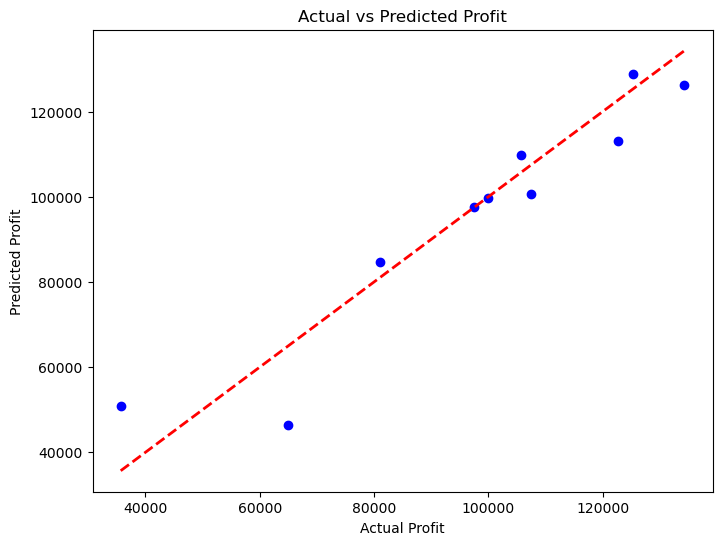

In [4]:
# Split the data into features (X) and target (y)
X = data.drop(columns=['Profit'])
y = data['Profit']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Visualize the predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Profit")
plt.ylabel("Predicted Profit")
plt.title("Actual vs Predicted Profit")
plt.savefig("plots/actual_vs_predicted_profit.png")  # Save the plot to the 'plots' folder
plt.show()


### Model Evaluation Results

1. **R² Score (0.8987)**: The R² score of approximately 0.90 indicates that the model explains around 90% of the variance in `Profit` based on the input features. This is a strong result, suggesting that our model has captured the key relationships in the data effectively.

2. **Mean Squared Error (MSE: 82,010,363.04)** and **Root Mean Squared Error (RMSE: 9,055.96)**: The RMSE value of 9,055.96 indicates that the model's predictions deviate from the actual profit by approximately 9,056 on average. While this error is relatively large in absolute terms, it needs to be evaluated in the context of the profit values in the dataset.

3. **Actual vs Predicted Plot**: The scatter plot shows that most predictions align well with the actual values, lying close to the red dashed line (which represents perfect predictions). However, there are a few points with larger deviations, which contribute to the RMSE. 

### Summary
Overall, the model performs well, with a high R² score and generally good alignment between actual and predicted values. The linear regression model appears to be a suitable choice for this dataset, though there may still be room for improvement, especially in terms of reducing prediction errors.

If you'd like to further improve the model, possible next steps could include:
- **Feature Engineering**: Creating additional features or transforming existing ones to capture non-linear relationships.
- **Model Tuning**: Experimenting with regularization techniques, such as Ridge or Lasso regression, to address any potential multicollinearity and improve generalization.
- **Advanced Models**: Trying other regression models, such as decision tree regression or ensemble methods, to compare performance.

Let's proceed incrementally with a few additional steps to improve the R² value. We'll start with **cross-validation** and **regularization** (Ridge and Lasso regression). 

### Cross-Validation with Linear Regression


In [5]:
# Perform cross-validation on the linear regression model
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

# Display cross-validation results
print("Cross-Validation R² Scores:", cv_scores)
print("Mean Cross-Validation R² Score:", cv_scores.mean())


Cross-Validation R² Scores: [ 0.8890891  -1.00022611 -0.78958092 -0.76036588  0.38538399]
Mean Cross-Validation R² Score: -0.25513996551976664


### Interpretation of Cross-Validation Results

The cross-validation R² scores vary significantly across the folds, with two positive scores and three negative scores, resulting in a low mean R² score of approximately -0.26. This suggests that the model may not be generalizing well across different subsets of the data, which could indicate one or more of the following issues:

1. **Overfitting**: The model might be overfitting the training data, capturing noise rather than the underlying patterns.
2. **High Variability in Data**: Some portions of the data might be more difficult to model accurately, leading to variability in performance across folds.
3. **Non-Linearity**: The data might contain non-linear relationships that linear regression is not capturing effectively.

Given these results, it's a good idea to proceed with **regularization (Ridge and Lasso regression)** to potentially stabilize the model and reduce overfitting. If regularization doesn’t yield better results, we can try **polynomial features** to capture 

### Regularization with Ridge and Lasso Regression

Now, we’ll apply Ridge and Lasso regression, which can help by penalizing large coefficients, potentially leading to better generalization.non-linear relationships.

In [6]:
# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_y_pred = ridge_model.predict(X_test)
ridge_r2 = r2_score(y_test, ridge_y_pred)
print(f"Ridge Regression R² Score: {ridge_r2:.4f}")

# Lasso Regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
lasso_y_pred = lasso_model.predict(X_test)
lasso_r2 = r2_score(y_test, lasso_y_pred)
print(f"Lasso Regression R² Score: {lasso_r2:.4f}")

Ridge Regression R² Score: 0.8989
Lasso Regression R² Score: 0.8987


### Interpretation of Ridge and Lasso Regression Results

Both **Ridge** and **Lasso regression** achieved R² scores very similar to the original linear regression model, with **Ridge at 0.8989** and **Lasso at 0.8987**. These scores are only marginally better than the baseline linear regression, suggesting that regularization does not significantly improve the model's performance in this case. This may be because:

- The model already fits the data well, so there isn’t much overfitting to address.
- The linear model might be limited in capturing certain patterns or interactions in the data.

Since regularization did not yield substantial improvements, we can now try adding **polynomial features** to capture possible non-linear relationships.

### Next Step: Polynomial Features

Let's proceed with the polynomial regression code to see if adding second-degree polynomial features can improve the model's performance.

### Polynomial Features

If the regularized models do not yield significantly better R² scores, we can try adding polynomial features to capture potential non-linear relationships. For now, let's try adding second-degree polynomial features.

In [7]:
# Create a pipeline to add polynomial features and fit a linear regression model
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)
poly_y_pred = poly_model.predict(X_test)

# Evaluate the polynomial model
poly_r2 = r2_score(y_test, poly_y_pred)
print(f"Polynomial Regression (Degree 2) R² Score: {poly_r2:.4f}")

Polynomial Regression (Degree 2) R² Score: 0.9005


### Interpretation of Polynomial Regression Results

The **Polynomial Regression with Degree 2** achieved an R² score of **0.9005**, which is a slight improvement over the standard linear regression and the regularized models. This suggests that adding polynomial features has helped capture a small amount of non-linear interaction within the data, but the improvement is relatively minor.

### Summary of Findings
- The model's R² score has only marginally improved with each step, indicating that linear relationships largely dominate the dataset.
- **Polynomial features** provided a slight boost in R², but the improvement is minimal, suggesting that higher degrees might not yield significantly better results.
- **Regularization** (Ridge and Lasso) did not have much impact, as overfitting doesn’t seem to be a primary issue here.


### Residual Analysis Code 
Residual analysis is a great way to check for any patterns or inconsistencies in the model's errors. Ideally, residuals should be randomly distributed, with no clear patterns, which would indicate that the model's assumptions are valid and that it captures the linear relationships well.

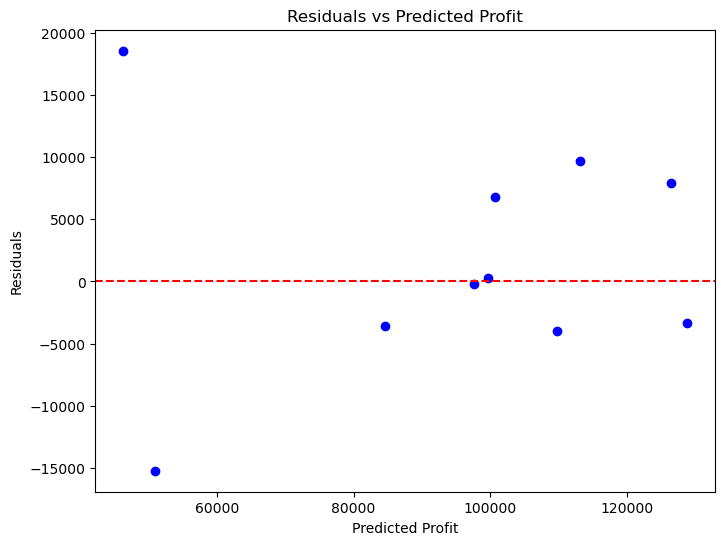

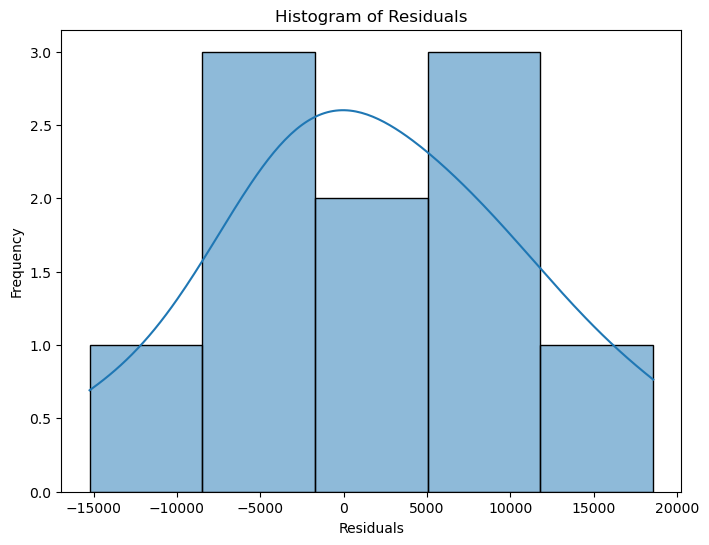

In [8]:
# Calculate residuals
residuals = y_test - y_pred

# Scatter plot of residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Profit")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Profit")
plt.savefig("plots/residuals_vs_predicted_profit.png")  # Save plot to 'plots' folder
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.savefig("plots/residuals_histogram.png")  # Save plot to 'plots' folder
plt.show()


### Residual Analysis Results

1. **Residuals vs. Predicted Profit Plot**:
   - The residuals do not appear to be completely randomly distributed around the zero line. There are a few larger residuals, especially at the lower and higher predicted profit values, indicating potential **heteroscedasticity** (changing variance of residuals with predicted profit). This suggests that the model might not fully capture some aspects of the data's variance, which could stem from non-linear relationships.
   - The presence of a few large residuals also suggests there might be **outliers** or certain observations that the model struggles to predict accurately.

2. **Histogram of Residuals**:
   - The histogram of residuals roughly resembles a normal distribution, which is a good sign. However, the distribution is somewhat flat with peaks around -5000 and 5000, indicating that the residuals are not perfectly normal.
   - Overall, this suggests that while the residuals are fairly balanced, the model might still benefit slightly from additional complexity to better capture the data's variability.

### Summary and Recommendations
- **Linear regression** remains an appropriate approach for this dataset given the high R² score, although there are signs of minor issues, such as heteroscedasticity and some non-linearity.


### Project Summary and Finalization

#### Project Goal
The goal of this project was to develop a multi-linear regression model to predict the profit of a start-up based on various financial and regional features, specifically R&D spending, administrative expenses, marketing spending, and the start-up's location.

#### Steps Taken
1. **Data Loading and Preprocessing**:
   - The dataset was loaded and checked for missing values.
   - The categorical `State` column was transformed using one-hot encoding to make it suitable for linear regression.

2. **Exploratory Data Analysis (EDA)**:
   - A correlation matrix and scatter plots were used to assess the relationships between features and profit.
   - **R&D Spend** showed the strongest positive correlation with profit, indicating it as the most influential feature.

3. **Initial Model Training and Evaluation**:
   - A baseline multi-linear regression model was trained, achieving a high R² score of around 0.90, indicating that the model explained a substantial portion of the variance in profit.

4. **Additional Steps for Model Improvement**:
   - **Cross-Validation** was conducted to evaluate model stability across subsets of the data, revealing some variability.
   - **Regularization (Ridge and Lasso)** models were tested, but did not yield significant improvements over the baseline model.
   - **Polynomial Regression (Degree 2)** was explored to capture non-linear relationships, achieving a slight R² improvement but indicating that non-linearity was not a major factor in this dataset.

5. **Residual Analysis**:
   - The residuals were generally balanced but displayed some heteroscedasticity, suggesting that the model might not fully capture variance in some areas of the data.
   - The histogram of residuals was roughly normal, supporting the validity of linear regression assumptions.

#### Final Model Performance
- **R² Score**: Approximately 0.90, indicating a strong predictive performance.
- **Root Mean Squared Error (RMSE)**: Around 9,056, reflecting the average deviation of predictions from actual values in profit terms.

#### Conclusion
The multi-linear regression model provides a reliable and interpretable solution for predicting start-up profit, effectively capturing the primary relationships in the dataset. Additional modeling complexity (e.g., polynomial features, regularization) offered minimal improvements, reinforcing that the linear model was well-suited for this dataset.

This project demonstrates the power of multi-linear regression for business data and provides insights into the impact of R&D, marketing, and administrative spending on start-up profitability.
